In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Step 1: Load Dataset
df = pd.read_csv("/content/Football_teams_price_data.csv")

In [14]:
# Step 2: Data Cleaning & Feature Selection
# Convert 'Price' column to numeric (remove commas)
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Generate a synthetic 'Ticket_Purchased' column for classification (Binary: 0 or 1)
df['Ticket_Purchased'] = np.where(df['AverageAttendance'] > df['AverageAttendance'].median(), 1, 0)

# Select relevant features for both classification & regression
features = [
    'AveragePlayerAge', 'TotalGoalsLastSeason', 'MatchesWonLastSeason',
    'AverageAttendance', 'TotalRevenueLastSeason', 'StadiumCapacity',
    'NumberOfTrophies', 'MarketValueOfSquad', 'PlayingStyle'
]

df = df[features + ['Price', 'Ticket_Purchased']]

# Encode categorical variables
categorical_features = ['PlayingStyle']
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [15]:
# Step 3: Split Data into Train & Test Sets
X = df.drop(columns=['Price', 'Ticket_Purchased'])
y_regression = df['Price']
y_classification = df['Ticket_Purchased']

X_train, X_test, y_train_reg, y_test_reg, y_train_class, y_test_class = train_test_split(
    X, y_regression, y_classification, test_size=0.2, random_state=42
)

In [16]:
# Step 4: Train XGBoost Models (Multi-Task Learning)
# Regression Model
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

# Classification Model
xgb_class = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)

# Train both models
xgb_reg.fit(X_train, y_train_reg)
xgb_class.fit(X_train, y_train_class)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:05:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
# Step 5: Model Evaluation
# Regression Evaluation
y_pred_reg = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f'Regression Mean Squared Error: {mse:.2f}')

# Classification Evaluation
y_pred_class = xgb_class.predict(X_test)
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f'Classification Accuracy: {accuracy:.4f}')
print(classification_report(y_test_class, y_pred_class))

Regression Mean Squared Error: 1715726297770494208.00
Classification Accuracy: 0.9980
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5098
           1       1.00      1.00      1.00      4902

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



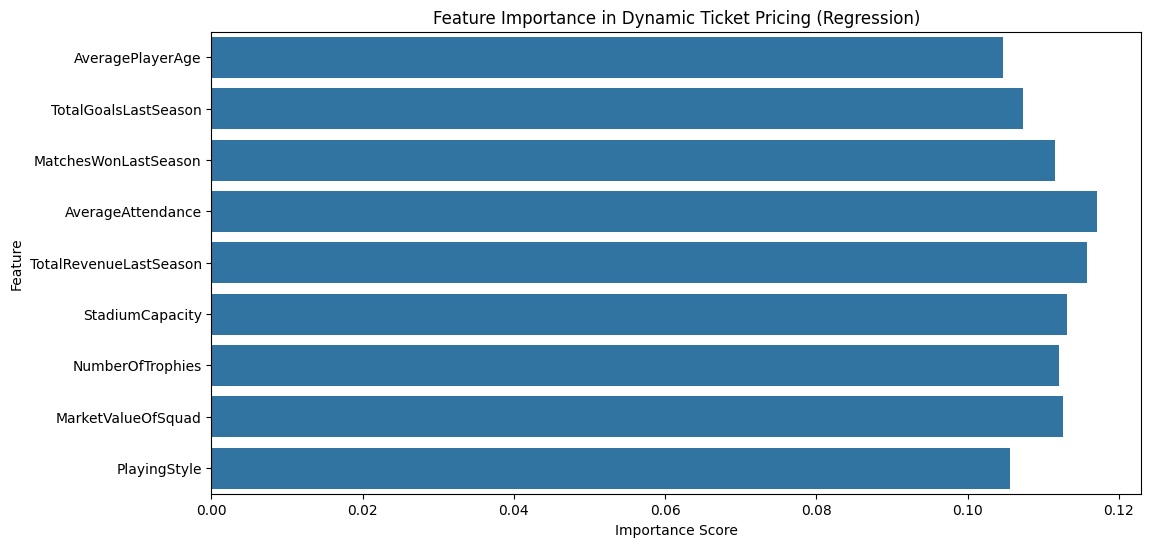

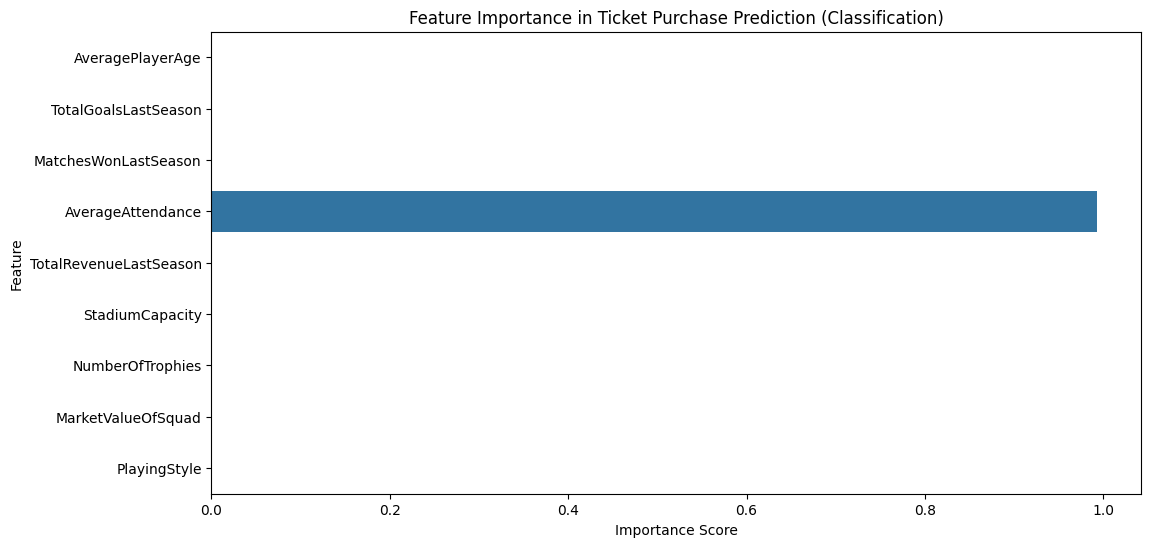

In [18]:
# Step 6: Feature Importance Plot
feature_importances_reg = xgb_reg.feature_importances_
feature_importances_class = xgb_class.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances_reg, y=feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in Dynamic Ticket Pricing (Regression)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances_class, y=feature_names)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in Ticket Purchase Prediction (Classification)')
plt.show()


In [19]:
# Step 7: Offer Recommendation System using Clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Apply K-Means clustering to segment fans
num_clusters = 3  # Assume 3 groups of fans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['FanSegment'] = kmeans.fit_predict(X_scaled)

# Define offer recommendations based on fan segment
offers = {
    0: "20% discount on tickets for upcoming matches!",
    1: "VIP Offer: Get a premium seat with a 30% discount!",
    2: "Buy a ticket and get a free drink at the next match!"
}

df['RecommendedOffer'] = df['FanSegment'].map(offers)

# Display sample recommendations
print(df[['FanSegment', 'RecommendedOffer']].head(10))

   FanSegment                                   RecommendedOffer
0           2  Buy a ticket and get a free drink at the next ...
1           1  VIP Offer: Get a premium seat with a 30% disco...
2           1  VIP Offer: Get a premium seat with a 30% disco...
3           1  VIP Offer: Get a premium seat with a 30% disco...
4           0      20% discount on tickets for upcoming matches!
5           2  Buy a ticket and get a free drink at the next ...
6           0      20% discount on tickets for upcoming matches!
7           1  VIP Offer: Get a premium seat with a 30% disco...
8           0      20% discount on tickets for upcoming matches!
9           1  VIP Offer: Get a premium seat with a 30% disco...
